# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
# from fastai.vision.all import *
import plotly.graph_objs as go
import plotly.graph_objs as go
import plotly.offline as pyoff

from tools import *

pyoff.init_notebook_mode(connected=True)

/home/anti/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# TRAINING PARAMETERS

size=128 #Image size
BS = 64
NB_EPOCHS = 10
MAX_LR = 3e-3

HIST = False

# DATA PREPARATION
path = untar_data(URLs.IMAGENETTE_160)
tfms = get_transforms(do_flip=False)
data = ImageList.from_folder(path).split_by_folder(valid='val').label_from_folder().transform(tfms, size=size).databunch(bs=BS).presize(size, scale=(0.35,1)).normalize(imagenet_stats)

# OTHERS
append_stats = partial(append_stats_n, HIST)
recorder = RecordExp()
activations_prestats=[]

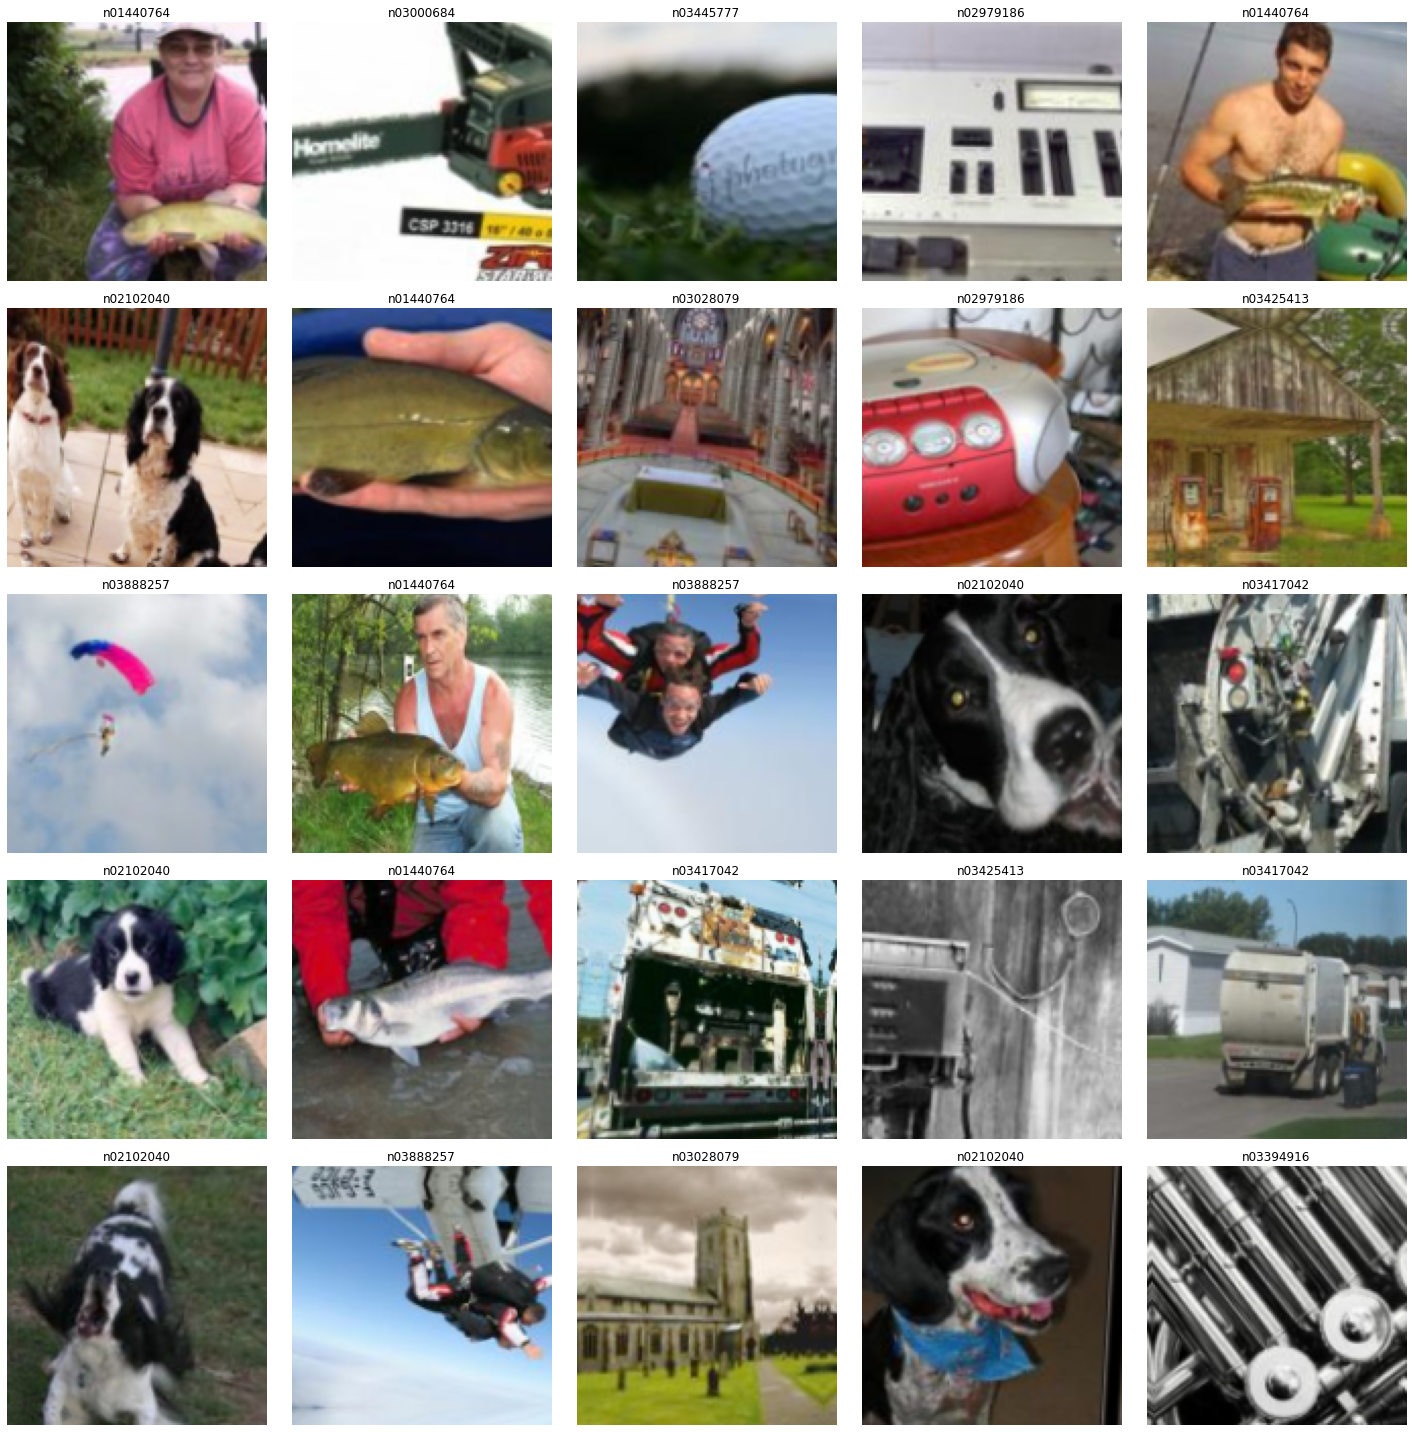

In [3]:
data.show_batch()

# Model building

In [4]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=0, sub=0, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x):
        x = F.leaky_relu(x,self.leak) if self.leak != 0 else F.relu(x)
        if self.sub != 0: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x
    
class ConvLayer(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=1, zero_bn=False, act=True, bias=False, **kwargs):
        super().__init__()
        self.bn = nn.BatchNorm2d(nf)
        nn.init.constant_(self.bn.weight, 0. if zero_bn else 1.)
        self.conv = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)
        if act: 
            self.relu = GeneralRelu(**kwargs)
            
        self.act = act
    
    def forward(self, x): 
        out = (self.bn(self.conv(x)))
        if self.act: out = self.relu(out)
        return out
    
    def has_relu(self):
        return self.act
    
    @property
    def bias(self):
        return -self.relu.sub

    @bias.setter
    def bias(self,v): self.relu.sub = -v
    
    @property
    def weight(self): return self.conv.weight
    
def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)
    
def is_monitored_layer(l):
    mon_layers = (nn.Linear, ConvLayer)
    return isinstance(l, mon_layers)

class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1, **kwargs):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [ConvLayer(ni, nh, 3, stride=stride, **kwargs),
                   ConvLayer(nh, nf, 3, zero_bn=True, act=False, **kwargs)
        ] if expansion == 1 else [
                   ConvLayer(ni, nh, 1, **kwargs),
                   ConvLayer(nh, nh, 3, stride=stride, **kwargs),
                   ConvLayer(nh, nf, 1, zero_bn=True, act=False, **kwargs)
        ]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act=False, **kwargs)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act_fn = GeneralRelu(**kwargs)

    def forward(self, x): 

        return self.act_fn(self.convs(x) + self.idconv(self.pool(x)))
    

class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=10, **kwargs):
        nfs = [c_in, (c_in+1)*8, 64, 64]
        stem = [ConvLayer(nfs[i], nfs[i+1], stride=2 if i==0 else 1, **kwargs)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2, **kwargs)
                  for i,l in enumerate(layers)]
        res = cls(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *res_layers,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(nfs[-1]*expansion, c_out),
        )
        #init_cnn(res)
        return res

    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride, **kwargs):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1, **kwargs)
              for i in range(n_blocks)])
    
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)

In [5]:
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

In [6]:
model = xresnet50(c_out=data.c)

In [7]:
def get_first_model():
    model = xresnet50(c_out=data.c)
    learn = Learner(data, model, metrics=[accuracy])
    
    return model, learn

# Pytorch default init

In [8]:
model, learn = get_first_model()


In [9]:
learn.summary()

XResNet
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm2d          [32, 64, 64]         64         True      
______________________________________________________________________
Conv2d               [32, 64, 64]         864        True      
______________________________________________________________________
GeneralRelu          [32, 64, 64]         0          False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
Conv2d               [64, 64, 64]         18,432     True      
______________________________________________________________________
GeneralRelu          [64, 64, 64]         0          False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________

In [10]:
out = get_prestat(learn, is_monitored_layer)
activations_prestats.append(out)

type <class 'list'>
ConvLayer: 
0.25584352016448975 / 0.4268014430999756

ConvLayer: 
0.11437615007162094 / 0.17937414348125458

ConvLayer: 
0.04375535249710083 / 0.07566361874341965

ConvLayer: 
0.02642088010907173 / 0.04078761860728264

ConvLayer: 
0.0115079116076231 / 0.018291912972927094

ConvLayer: 
0.0 / 0.0

ConvLayer: 
-0.0010400705505162477 / 0.06311719864606857

ConvLayer: 
0.0112233841791749 / 0.017000125721096992

ConvLayer: 
0.003097482956945896 / 0.005558434873819351

ConvLayer: 
0.0 / 0.0

ConvLayer: 
0.009845046326518059 / 0.016198385506868362

ConvLayer: 
0.00359543040394783 / 0.005579083226621151

ConvLayer: 
0.0 / 0.0

ConvLayer: 
0.008416369557380676 / 0.013387652114033699

ConvLayer: 
0.004083537496626377 / 0.005826500244438648

ConvLayer: 
0.0 / 0.0

ConvLayer: 
0.0005414154729805887 / 0.025084195658564568

ConvLayer: 
0.0036511276848614216 / 0.006042877212166786

ConvLayer: 
0.0013799264561384916 / 0.0021217537578195333

ConvLayer: 
0.0 / 0.0

ConvLayer: 
0.00386

In [11]:
model, learn = get_first_model()

learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time


Process Process-1:
Process Process-2:
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3dd1712040>
Traceback (most recent call last):
  File "/home/anti/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1202, in __del__
    def __del__(self):
  File "/home/anti/.local/lib/python3.8/site-packages/torch/utils/data/_utils/signal_handling.py", line 66, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 864823) exited unexpectedly with exit code 1. Details are lost due to multiprocessing. Rerunning with num_workers=0 may give better error trace.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [15]:
with Hooks(model, append_stats) as hooks: learn.fit_one_cycle(NB_EPOCHS, MAX_LR)

epoch,train_loss,valid_loss,accuracy,time
0,1.511201,1.850102,0.446000,00:28
1,1.353026,2.705333,0.346000,00:28
2,1.199713,2.714806,0.328000,00:28
3,1.003369,1.155494,0.638000,00:28
4,0.846217,1.621406,0.572000,00:28
5,0.760427,0.793311,0.736000,00:28
6,0.640127,0.553325,0.814000,00:28
7,0.554693,0.495320,0.842000,00:28
8,0.493664,0.367202,0.888000,00:28
9,0.434475,0.373780,0.890000,00:28


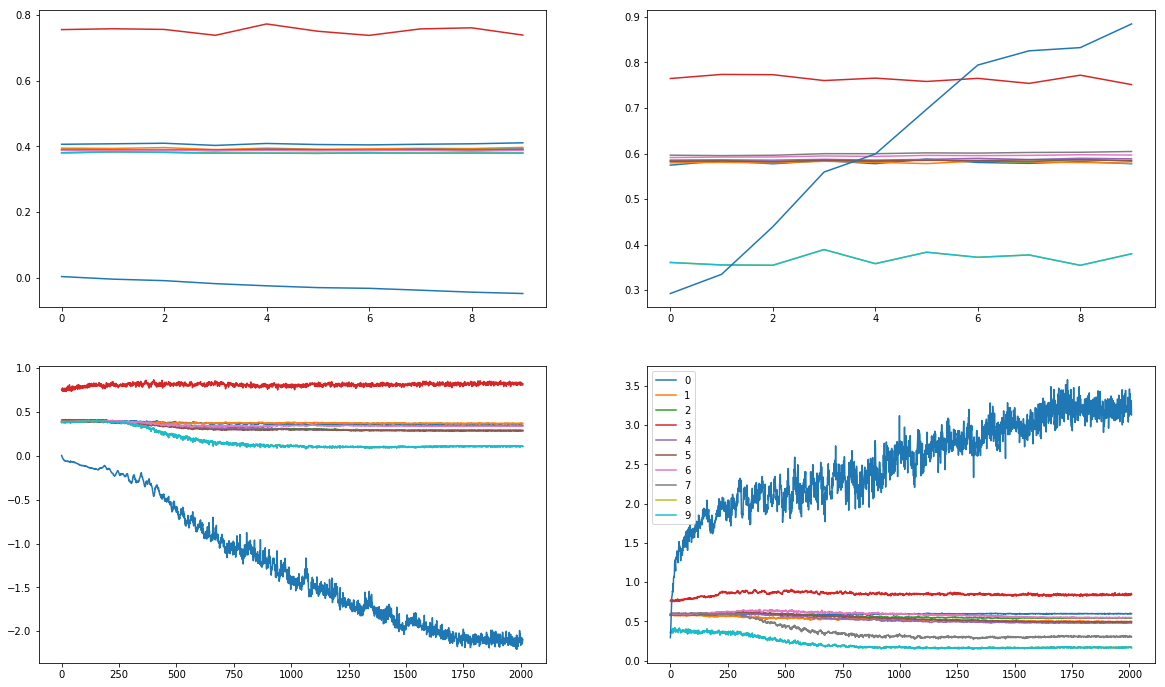

In [16]:
recorder.add_exp(learn.recorder, "pytorch default")
viz(hooks)

In [17]:
if HIST:
    stats_ratio_zeros(hooks)

# Kaiming init

In [18]:
model, learn = get_first_model()
get_prestat(learn, is_monitored_layer)

ConvLayer: 
[tensor(0.2686)] / [tensor(0.4321)]

ConvLayer: 
[tensor(0.1062)] / [tensor(0.1756)]

ConvLayer: 
[tensor(0.0384)] / [tensor(0.0658)]

ConvLayer: 
[tensor(0.0228)] / [tensor(0.0354)]

ConvLayer: 
[tensor(0.0087)] / [tensor(0.0138)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(-8.2757e-05)] / [tensor(0.0624)]

ConvLayer: 
[tensor(0.0103)] / [tensor(0.0146)]

ConvLayer: 
[tensor(0.0042)] / [tensor(0.0067)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.0136)] / [tensor(0.0191)]

ConvLayer: 
[tensor(0.0049)] / [tensor(0.0070)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.0095)] / [tensor(0.0143)]

ConvLayer: 
[tensor(0.0037)] / [tensor(0.0058)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(-0.0002)] / [tensor(0.0263)]

ConvLayer: 
[tensor(0.0038)] / [tensor(0.0064)]

ConvLayer: 
[tensor(0.0014)] / [tensor(0.0024)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.0044)] / [tensor(0.0071)]

ConvL

[([tensor(0.2686)], [tensor(0.4321)]),
 ([tensor(0.1062)], [tensor(0.1756)]),
 ([tensor(0.0384)], [tensor(0.0658)]),
 ([tensor(0.0228)], [tensor(0.0354)]),
 ([tensor(0.0087)], [tensor(0.0138)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(-8.2757e-05)], [tensor(0.0624)]),
 ([tensor(0.0103)], [tensor(0.0146)]),
 ([tensor(0.0042)], [tensor(0.0067)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0136)], [tensor(0.0191)]),
 ([tensor(0.0049)], [tensor(0.0070)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0095)], [tensor(0.0143)]),
 ([tensor(0.0037)], [tensor(0.0058)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(-0.0002)], [tensor(0.0263)]),
 ([tensor(0.0038)], [tensor(0.0064)]),
 ([tensor(0.0014)], [tensor(0.0024)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0044)], [tensor(0.0071)]),
 ([tensor(0.0018)], [tensor(0.0028)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0033)], [tensor(0.0053)]),
 ([tensor(0.0013)], [tensor(0.0020)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0036)], [tensor(0.0062)]

In [19]:
def init_cnn(m, leak=0):
    if not isinstance(m, ConvLayer) and getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight, a=leak)
    for l in m.children(): init_cnn(l)

In [20]:
init_cnn(model)

In [21]:
out = get_prestat(learn, is_monitored_layer)
activations_prestats.append(out)

ConvLayer: 
[tensor(0.5920)] / [tensor(0.9312)]

ConvLayer: 
[tensor(0.4801)] / [tensor(0.8075)]

ConvLayer: 
[tensor(0.5170)] / [tensor(0.8090)]

ConvLayer: 
[tensor(0.8835)] / [tensor(1.3291)]

ConvLayer: 
[tensor(0.8430)] / [tensor(1.2474)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(-0.1461)] / [tensor(1.9231)]

ConvLayer: 
[tensor(0.6509)] / [tensor(1.1005)]

ConvLayer: 
[tensor(0.7089)] / [tensor(1.1354)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.5305)] / [tensor(0.8859)]

ConvLayer: 
[tensor(0.3980)] / [tensor(0.7933)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.7608)] / [tensor(1.0483)]

ConvLayer: 
[tensor(0.6048)] / [tensor(1.0220)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(-0.1505)] / [tensor(1.7137)]

ConvLayer: 
[tensor(0.4561)] / [tensor(0.8420)]

ConvLayer: 
[tensor(0.5457)] / [tensor(0.8185)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.5957)] / [tensor(1.0034)]

ConvLayer

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


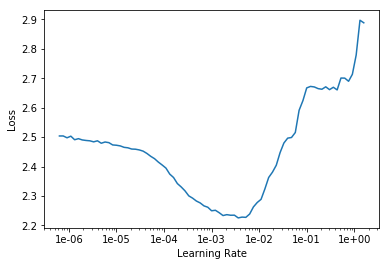

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
with Hooks(model, append_stats) as hooks: learn.fit_one_cycle(NB_EPOCHS, MAX_LR)

epoch,train_loss,valid_loss,accuracy,time
0,1.480708,2.470682,0.438000,00:28
1,1.354276,1.563909,0.546000,00:28
2,1.181079,2.102196,0.470000,00:28
3,0.993427,1.698210,0.546000,00:28
4,0.864465,0.879617,0.744000,00:28
5,0.718922,0.708573,0.794000,00:28
6,0.628974,0.477984,0.860000,00:28
7,0.532156,0.404031,0.876000,00:28
8,0.450332,0.347893,0.900000,00:28
9,0.417386,0.352162,0.894000,00:28


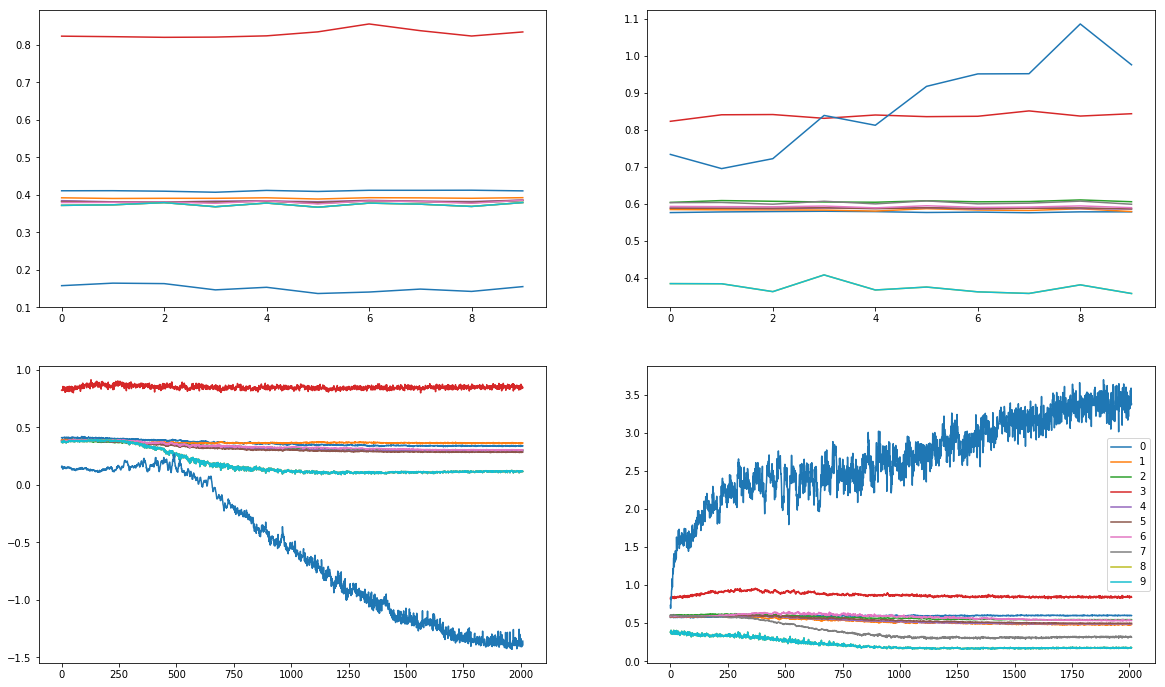

In [24]:
recorder.add_exp(learn.recorder, 'kaiming init')
viz(hooks)

In [25]:
if HIST:
    stats_ratio_zeros(hooks)

# LSUV init

In [26]:
def lsuv_module(m, xb):
    h = Hook(m, append_stat)

    while mdl(xb) is not None and abs(h.mean)  > 1e-3: m.bias -= h.mean
    while mdl(xb) is not None and abs(h.std-1) > 1e-3: m.weight.data /= h.std

    h.remove()
    return h.mean,h.std

In [27]:
model, learn = get_first_model()
#layers_monitored = find_modules(model, is_monitored_layer)

get_prestat(learn, is_monitored_layer)

ConvLayer: 
[tensor(0.2283)] / [tensor(0.3791)]

ConvLayer: 
[tensor(0.0849)] / [tensor(0.1379)]

ConvLayer: 
[tensor(0.0395)] / [tensor(0.0608)]

ConvLayer: 
[tensor(0.0198)] / [tensor(0.0317)]

ConvLayer: 
[tensor(0.0091)] / [tensor(0.0124)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.0009)] / [tensor(0.0550)]

ConvLayer: 
[tensor(0.0107)] / [tensor(0.0144)]

ConvLayer: 
[tensor(0.0022)] / [tensor(0.0038)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.0072)] / [tensor(0.0114)]

ConvLayer: 
[tensor(0.0029)] / [tensor(0.0048)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.0073)] / [tensor(0.0119)]

ConvLayer: 
[tensor(0.0032)] / [tensor(0.0050)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(-0.0017)] / [tensor(0.0230)]

ConvLayer: 
[tensor(0.0028)] / [tensor(0.0050)]

ConvLayer: 
[tensor(0.0011)] / [tensor(0.0019)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.0034)] / [tensor(0.0052)]

ConvLayer:

[([tensor(0.2283)], [tensor(0.3791)]),
 ([tensor(0.0849)], [tensor(0.1379)]),
 ([tensor(0.0395)], [tensor(0.0608)]),
 ([tensor(0.0198)], [tensor(0.0317)]),
 ([tensor(0.0091)], [tensor(0.0124)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0009)], [tensor(0.0550)]),
 ([tensor(0.0107)], [tensor(0.0144)]),
 ([tensor(0.0022)], [tensor(0.0038)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0072)], [tensor(0.0114)]),
 ([tensor(0.0029)], [tensor(0.0048)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0073)], [tensor(0.0119)]),
 ([tensor(0.0032)], [tensor(0.0050)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(-0.0017)], [tensor(0.0230)]),
 ([tensor(0.0028)], [tensor(0.0050)]),
 ([tensor(0.0011)], [tensor(0.0019)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0034)], [tensor(0.0052)]),
 ([tensor(0.0013)], [tensor(0.0021)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0030)], [tensor(0.0048)]),
 ([tensor(0.0013)], [tensor(0.0020)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0032)], [tensor(0.0053)]),
 (

In [28]:
def is_conv_layer(l):
    mon_layers = (ConvLayer)
    if isinstance(l, ConvLayer) and not l.has_relu():
        return False
    
    return isinstance(l, mon_layers)

In [29]:

def lsuv_conv(m, xb, model, debug=False):
    h = Hook2(m, init_stats)
      

    
    while model(xb) is not None and abs(h.stats[0][-1])  > 1e-3: 
        if debug: print(f'Len stats: {len(h.stats[0])}')
        if debug: print(f'Working on the bias of module {str(h.mod)[:9]}, val before= {m.bias}')
        m.bias -= h.stats[0][-1]
        if debug: print(f'after = {m.bias}\n')
       
     
    while model(xb) is not None and abs(h.stats[1][-1]-1) > 1e-3: 
        if debug: print(f'Len stats: {len(h.stats[0])}')
        if debug: print(f'Working on the std of module {str(h.mod)[:9]}, val before= {h.stats[1][-1]}')
        m.weight.data /= h.stats[1][-1]
        if debug: print(f'after = {m.weight.data.std()}\n')
    h.remove()    
    return h.stats[0][-1], h.stats[1][-1]

In [30]:
xb = next(iter(data.train_dl))

In [31]:
model, learn = get_first_model()
layers_monitored = find_modules(model, is_monitored_layer)

get_prestat(learn, is_monitored_layer)

ConvLayer: 
[tensor(0.3087)] / [tensor(0.4725)]

ConvLayer: 
[tensor(0.1171)] / [tensor(0.2066)]

ConvLayer: 
[tensor(0.0498)] / [tensor(0.0858)]

ConvLayer: 
[tensor(0.0182)] / [tensor(0.0336)]

ConvLayer: 
[tensor(0.0091)] / [tensor(0.0138)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.0030)] / [tensor(0.0774)]

ConvLayer: 
[tensor(0.0119)] / [tensor(0.0212)]

ConvLayer: 
[tensor(0.0054)] / [tensor(0.0082)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.0117)] / [tensor(0.0182)]

ConvLayer: 
[tensor(0.0044)] / [tensor(0.0070)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.0100)] / [tensor(0.0166)]

ConvLayer: 
[tensor(0.0041)] / [tensor(0.0065)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.0021)] / [tensor(0.0337)]

ConvLayer: 
[tensor(0.0071)] / [tensor(0.0101)]

ConvLayer: 
[tensor(0.0023)] / [tensor(0.0038)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.0060)] / [tensor(0.0084)]

ConvLayer: 

[([tensor(0.3087)], [tensor(0.4725)]),
 ([tensor(0.1171)], [tensor(0.2066)]),
 ([tensor(0.0498)], [tensor(0.0858)]),
 ([tensor(0.0182)], [tensor(0.0336)]),
 ([tensor(0.0091)], [tensor(0.0138)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0030)], [tensor(0.0774)]),
 ([tensor(0.0119)], [tensor(0.0212)]),
 ([tensor(0.0054)], [tensor(0.0082)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0117)], [tensor(0.0182)]),
 ([tensor(0.0044)], [tensor(0.0070)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0100)], [tensor(0.0166)]),
 ([tensor(0.0041)], [tensor(0.0065)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0021)], [tensor(0.0337)]),
 ([tensor(0.0071)], [tensor(0.0101)]),
 ([tensor(0.0023)], [tensor(0.0038)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0060)], [tensor(0.0084)]),
 ([tensor(0.0024)], [tensor(0.0032)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0056)], [tensor(0.0091)]),
 ([tensor(0.0028)], [tensor(0.0039)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0055)], [tensor(0.0086)]),
 ([

In [32]:
init_cnn(model, leak=0)

get_prestat(learn, is_monitored_layer)

ConvLayer: 
[tensor(0.5959)] / [tensor(0.9569)]

ConvLayer: 
[tensor(0.4871)] / [tensor(0.8133)]

ConvLayer: 
[tensor(0.4625)] / [tensor(0.7109)]

ConvLayer: 
[tensor(0.7732)] / [tensor(1.1679)]

ConvLayer: 
[tensor(0.6622)] / [tensor(1.1334)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.0063)] / [tensor(1.7302)]

ConvLayer: 
[tensor(0.6262)] / [tensor(1.1208)]

ConvLayer: 
[tensor(0.8881)] / [tensor(1.2868)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.6218)] / [tensor(1.0813)]

ConvLayer: 
[tensor(0.7572)] / [tensor(1.2236)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.6390)] / [tensor(0.9738)]

ConvLayer: 
[tensor(0.6233)] / [tensor(0.9153)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.1442)] / [tensor(1.6109)]

ConvLayer: 
[tensor(0.7157)] / [tensor(1.0736)]

ConvLayer: 
[tensor(0.6614)] / [tensor(1.0913)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.7798)] / [tensor(1.2029)]

ConvLayer: 

[([tensor(0.5959)], [tensor(0.9569)]),
 ([tensor(0.4871)], [tensor(0.8133)]),
 ([tensor(0.4625)], [tensor(0.7109)]),
 ([tensor(0.7732)], [tensor(1.1679)]),
 ([tensor(0.6622)], [tensor(1.1334)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.0063)], [tensor(1.7302)]),
 ([tensor(0.6262)], [tensor(1.1208)]),
 ([tensor(0.8881)], [tensor(1.2868)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.6218)], [tensor(1.0813)]),
 ([tensor(0.7572)], [tensor(1.2236)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.6390)], [tensor(0.9738)]),
 ([tensor(0.6233)], [tensor(0.9153)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.1442)], [tensor(1.6109)]),
 ([tensor(0.7157)], [tensor(1.0736)]),
 ([tensor(0.6614)], [tensor(1.0913)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.7798)], [tensor(1.2029)]),
 ([tensor(0.7096)], [tensor(1.1987)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.6358)], [tensor(0.9576)]),
 ([tensor(0.6858)], [tensor(1.0495)]),
 ([tensor(0.)], [tensor(0.)]),
 ([tensor(0.7954)], [tensor(1.1426)]),
 ([

In [33]:
for i, m in enumerate(find_modules(model, is_conv_layer)): 
    print(f'\n\nLayer {i}')
    print(lsuv_conv(m, xb[0], model))



Layer 0
(tensor(0.0500), tensor(1.0000))


Layer 1
(tensor(0.1642), tensor(1.0000))


Layer 2
(tensor(0.1351), tensor(1.))


Layer 3
(tensor(-0.1832), tensor(1.))


Layer 4
(tensor(0.1181), tensor(1.))


Layer 5
(tensor(-0.0798), tensor(1.0000))


Layer 6
(tensor(0.0361), tensor(1.))


Layer 7
(tensor(-0.1104), tensor(1.0000))


Layer 8
(tensor(0.0891), tensor(1.))


Layer 9
(tensor(-0.0998), tensor(1.0000))


Layer 10
(tensor(0.1320), tensor(1.0000))


Layer 11
(tensor(-0.0774), tensor(1.0000))


Layer 12
(tensor(0.1051), tensor(1.))


Layer 13
(tensor(-0.1915), tensor(1.0000))


Layer 14
(tensor(0.1214), tensor(1.0000))


Layer 15
(tensor(-0.0127), tensor(1.0000))


Layer 16
(tensor(0.0799), tensor(1.0000))


Layer 17
(tensor(-0.1326), tensor(1.0000))


Layer 18
(tensor(0.1346), tensor(1.))


Layer 19
(tensor(-0.0682), tensor(1.))


Layer 20
(tensor(0.1520), tensor(1.0000))


Layer 21
(tensor(-0.0073), tensor(1.0000))


Layer 22
(tensor(0.1041), tensor(1.0000))


Layer 23
(tensor(-

In [34]:
out = get_prestat(learn, is_monitored_layer)
activations_prestats.append(out)

ConvLayer: 
[tensor(0.0612)] / [tensor(1.0386)]

ConvLayer: 
[tensor(0.1853)] / [tensor(0.9998)]

ConvLayer: 
[tensor(0.2189)] / [tensor(1.0324)]

ConvLayer: 
[tensor(-0.0309)] / [tensor(1.1865)]

ConvLayer: 
[tensor(0.2006)] / [tensor(1.1509)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(-0.1053)] / [tensor(2.2646)]

ConvLayer: 
[tensor(0.0091)] / [tensor(1.1477)]

ConvLayer: 
[tensor(0.1421)] / [tensor(1.1420)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(-0.0333)] / [tensor(1.1739)]

ConvLayer: 
[tensor(0.1902)] / [tensor(1.1950)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.0009)] / [tensor(1.1400)]

ConvLayer: 
[tensor(0.2081)] / [tensor(1.0943)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(0.0976)] / [tensor(1.9687)]

ConvLayer: 
[tensor(0.0595)] / [tensor(1.1707)]

ConvLayer: 
[tensor(0.2020)] / [tensor(1.1626)]

ConvLayer: 
[tensor(0.)] / [tensor(0.)]

ConvLayer: 
[tensor(-0.1036)] / [tensor(1.1198)]

ConvLay

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


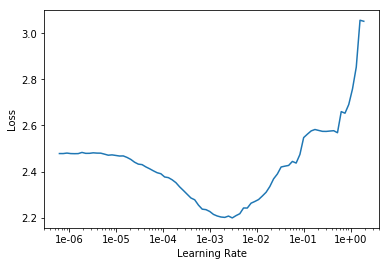

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
with Hooks(model, append_stats) as hooks: learn.fit_one_cycle(NB_EPOCHS, MAX_LR)

epoch,train_loss,valid_loss,accuracy,time
0,1.540162,2.394483,0.440000,00:28
1,1.334487,1.909398,0.484000,00:28
2,1.197339,1.955653,0.524000,00:28
3,1.023513,1.296350,0.604000,00:28
4,0.874735,0.751028,0.772000,00:28
5,0.757048,0.763461,0.800000,00:28
6,0.637833,0.544311,0.834000,00:28
7,0.542591,0.439144,0.874000,00:28
8,0.480858,0.421775,0.878000,00:28
9,0.420707,0.404189,0.890000,00:28


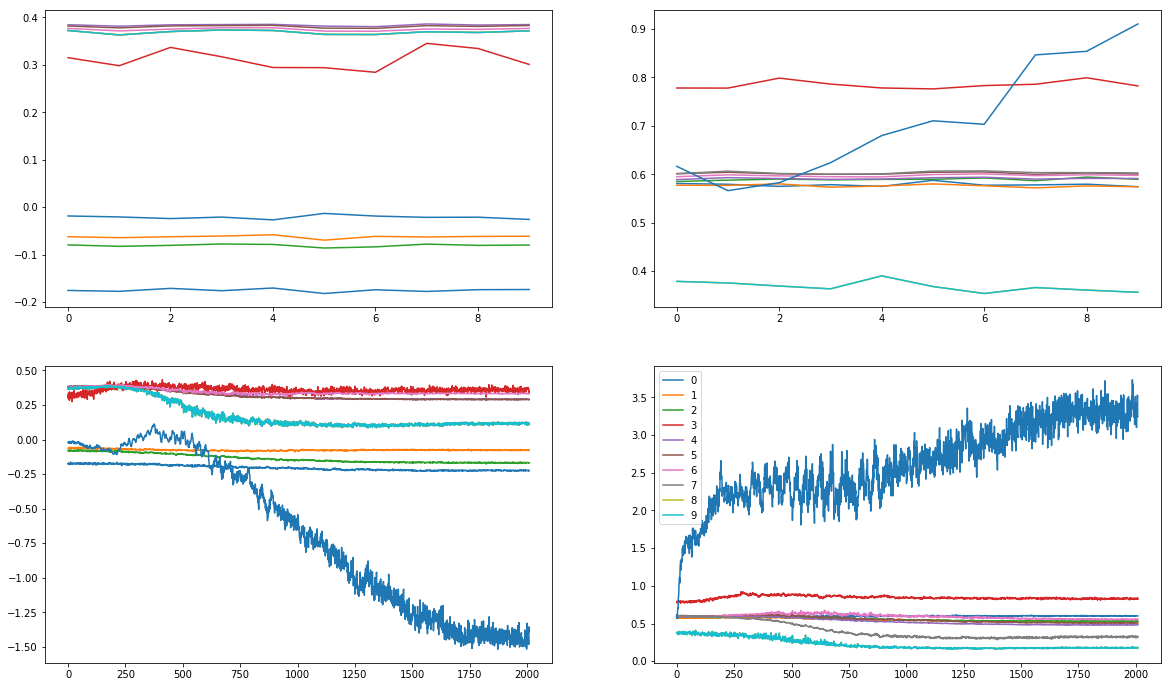

In [37]:
recorder.add_exp(learn.recorder, "LSUV init")
viz(hooks)

In [38]:
if HIST:
    stats_ratio_zeros(hooks)

# Results

In [39]:
recorder.plot_results_plotly(NB_EPOCHS, True)

In [40]:
x = range(len(activations_prestats[0]))
mean_prestat = []
std_prestat = []
for exp in activations_prestats:
    exp = np.array(exp)
    mean_prestat.append(exp[:, 0])
    std_prestat.append(exp[:, 1])

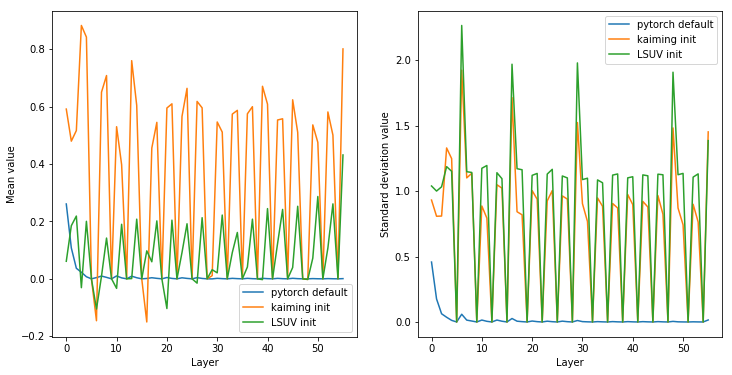

In [41]:



fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax1.set_xlabel('Layer')
ax1.set_ylabel('Mean value')

ax2.set_xlabel('Layer')
ax2.set_ylabel('Standard deviation value')
for i, m in enumerate(mean_prestat):
    ax1.plot(x, m, label=recorder.labels[i])
for i, s in enumerate(std_prestat):
    ax2.plot(x, s, label=recorder.labels[i])
    


ax1.legend()    
ax2.legend()